# Exercise 4.10 – Part 1: Customer Profiling & Final Dataset Preparation

This notebook finalizes the Instacart analysis by applying data security (PII) checks, creating regional segmentation and customer profiles, and producing final outputs (charts + exported dataset) required for the final Excel report.

In [6]:
# --------------------------------------------------
# Step 2A: Import required libraries
# --------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [7]:
# --------------------------------------------------
# Step 2B: Load prepared Instacart dataset (Exercise 4.9)
# --------------------------------------------------

path_prepared = r"F:\Data Analytics\Projects\Instacart_Basket_Analysis\Instacart Basket Analysis 01-05-2026\02 Data\Prepared Data"
file_name = "instacart_prepared_exercise_4_9.pkl"

df = pd.read_pickle(os.path.join(path_prepared, file_name))

# Confirm dataset structure
df.shape

(32641268, 27)

In [8]:
# --------------------------------------------------
# Step 2C: Inspect columns and data types
# --------------------------------------------------

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32641268 entries, 0 to 32641267
Data columns (total 27 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   order_id                    int64   
 1   user_id                     int64   
 2   order_number                int64   
 3   orders_day_of_week          int64   
 4   order_hour_of_day           int64   
 5   days_since_prior_order      float64 
 6   product_id                  float64 
 7   add_to_cart_order           float64 
 8   reordered                   float64 
 9   product_name                object  
 10  aisle_id                    float64 
 11  department_id               float64 
 12  prices                      float64 
 13  _merge                      category
 14  max_order                   int64   
 15  loyalty_flag                object  
 16  mean_price                  float64 
 17  spending_flag               object  
 18  median_days_between_orders  float64 
 19

### Step 2: Data Security & PII Review

The dataset contains several columns that would normally be considered personally identifiable information (PII), including age, gender, state, income, family status, and number of dependents. These attributes were reviewed prior to analysis to assess potential data security concerns.

All customer-related variables in this dataset were **synthetically generated for educational purposes**, as stated in the project documentation. No real customer identities are represented, and no direct identifiers such as names, email addresses, or physical addresses are included.

Because the data is fabricated and anonymized at the source, no additional masking or removal of columns was required. The customer attributes were retained to support profiling, segmentation, and marketing analysis tasks required for this Exercise and the final Instacart report.

### Step 3: Regional Segmentation (U.S. Census Regions)

In this step, a new **region** column is created based on the customer's U.S. state.
Regions follow the official U.S. Census Bureau classification:
Northeast, Midwest, South, and West.

This regional segmentation allows Instacart to compare customer behavior and
spending patterns across geographic areas.


In [9]:
# ------------------------------------------------------------
# Step 3A: Define U.S. Census regions by state
# ------------------------------------------------------------

northeast = [
    'Maine', 'New Hampshire', 'Vermont', 'Massachusetts',
    'Rhode Island', 'Connecticut',
    'New York', 'Pennsylvania', 'New Jersey'
]

midwest = [
    'Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio',
    'North Dakota', 'South Dakota', 'Nebraska', 'Kansas',
    'Minnesota', 'Iowa', 'Missouri'
]

south = [
    'Delaware', 'Maryland', 'District of Columbia', 'Virginia',
    'West Virginia', 'North Carolina', 'South Carolina',
    'Georgia', 'Florida',
    'Kentucky', 'Tennessee', 'Mississippi', 'Alabama',
    'Oklahoma', 'Texas', 'Arkansas', 'Louisiana'
]

west = [
    'Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado',
    'Arizona', 'New Mexico',
    'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii'
]


In [10]:
# ------------------------------------------------------------
# Step 3B: Assign region based on state
# ------------------------------------------------------------

def assign_region(state):
    if state in northeast:
        return 'Northeast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in west:
        return 'West'
    else:
        return 'Unknown'

df['region'] = df['state'].apply(assign_region)


In [11]:
# Verify region assignment
df['region'].value_counts(dropna=False)

region
South        10870719
West          8353182
Midwest       7652535
Northeast     5764832
Name: count, dtype: int64

In [12]:
# ----------------------------------------
# Step 3C: Spending behavior by U.S. region
# ----------------------------------------

# Crosstab of region vs spending category
region_spending_ct = pd.crosstab(
    df['region'],
    df['spending_flag'],
    normalize='index'
)

region_spending_ct


spending_flag,High spender,Low spender
region,,
Midwest,0.020561,0.979439
Northeast,0.018935,0.981065
South,0.019474,0.980526
West,0.019374,0.980626


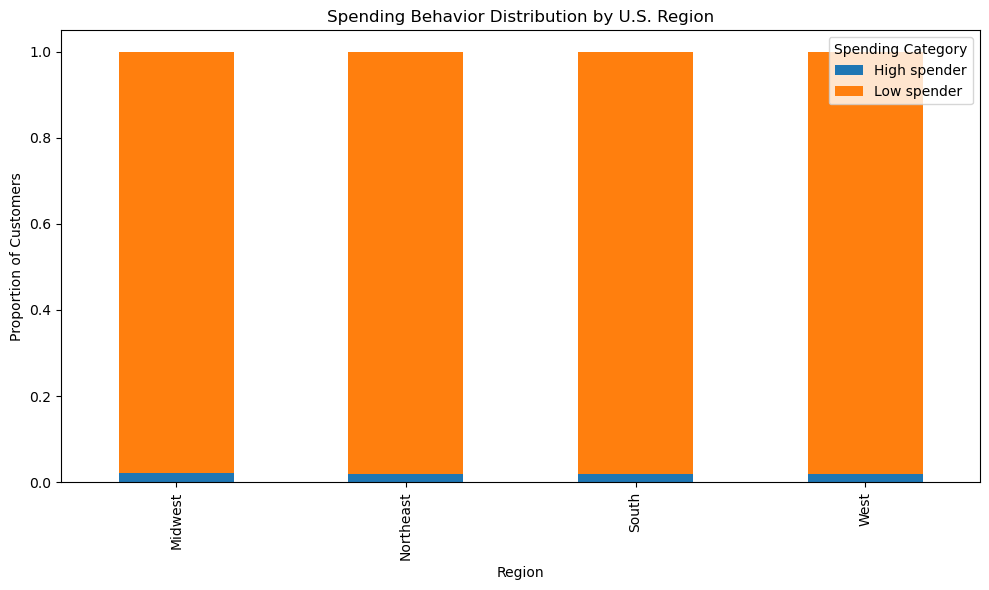

In [13]:
# Visualize spending distribution by region
region_spending_ct.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)

plt.title('Spending Behavior Distribution by U.S. Region')
plt.xlabel('Region')
plt.ylabel('Proportion of Customers')
plt.legend(title='Spending Category')
plt.tight_layout()
plt.show()

### Step 3C: Regional Differences in Spending Behavior

This analysis compares customer spending behavior across U.S. Census regions by crossing the newly created **region** variable with the **spending_flag** classification.

The stacked bar chart shows the distribution of customer spending behavior (high vs. low spenders) across the four U.S. Census regions: Midwest, Northeast, South, and West.

Across all regions, the vast majority of customers are classified as low spenders, with high spenders representing a very small proportion of the customer base in each region. The proportions of high spenders are remarkably consistent across regions, ranging from approximately 1.9% to 2.1%.

The Midwest shows a slightly higher proportion of high spenders compared to the other regions, while the Northeast, South, and West display nearly identical distributions. However, these differences are minimal and do not indicate a strong regional effect on spending behavior.

Overall, this analysis suggests that customer spending patterns are broadly similar across U.S. regions, and that geographic location alone is not a strong differentiator of high-spending behavior. This implies that Instacart’s high-value customers are distributed relatively evenly nationwide, and that marketing strategies targeting high spenders may be more effective if based on customer-level characteristics rather than regional location alone.

In [14]:
# ---------------------------------------------
# Step 4A: Create low-activity customer flag
# ---------------------------------------------
# Low-activity customers are defined as customers
# with fewer than 5 total orders.

df['low_activity_flag'] = np.where(
    df['max_order'] < 5,
    'Low activity',
    'Active'
)

# Inspect distribution of activity levels
df['low_activity_flag'].value_counts()

low_activity_flag
Active          31929979
Low activity      711289
Name: count, dtype: int64

In [15]:
# ---------------------------------------------
# Step 4B: Exclude low-activity customers
# ---------------------------------------------
# Keep only customers with 5 or more orders.

df_active = df[df['low_activity_flag'] == 'Active']

# Confirm new dataset shape
df_active.shape

(31929979, 29)

In [16]:
# ---------------------------------------------
# Step 4C: Validate exclusion results
# ---------------------------------------------

# Check that no low-activity customers remain
df_active['low_activity_flag'].value_counts()


low_activity_flag
Active    31929979
Name: count, dtype: int64

### Step 4: Exclusion of Low-Activity Customers

To align the analysis with business priorities, customers with fewer than five total orders were classified as low-activity and excluded from the dataset. A new column, `low_activity_flag`, was created based on the `max_order` variable to distinguish between active and low-activity customers.

A total of 711,289 low-activity customer records were identified and removed. The resulting dataset retains 31,929,979 rows representing customers with meaningful engagement levels. This ensures that subsequent analyses focus on customers who generate sustained revenue for Instacart, as required by the CFO.

### Step 5: Customer Profiling

In this step, a customer profiling variable was created to group customers into meaningful segments based on demographic and behavioral attributes.  
The profile combines age, household composition, spending behavior, and order frequency to support marketing and business strategy analysis.

The resulting profiles represent distinct customer types such as young singles, families, affluent frequent shoppers, and budget-conscious customers.


In [18]:
# ---------------------------------------------
# Step 5B: Create customer profiling variable
# ---------------------------------------------

def assign_customer_profile(row):
    # Demographic-based profiles
    if row['age'] < 35 and row['n_dependants'] == 0:
        return 'Young single'
    elif row['age'] < 35 and row['n_dependants'] >= 1:
        return 'Young parent'
    elif row['age'] >= 35 and row['n_dependants'] >= 1:
        return 'Family household'
    
    # Behavior-based profiles
    elif row['spending_flag'] == 'High spender' and row['order_frequency_flag'] == 'Frequent customer':
        return 'Affluent frequent shopper'
    elif row['spending_flag'] == 'Low spender' and row['order_frequency_flag'] == 'Non-frequent customer':
        return 'Budget occasional shopper'
    
    # Catch-all
    else:
        return 'Other'


# Apply profiling logic
df_active['customer_profile'] = df_active.apply(assign_customer_profile, axis=1)

# Inspect profile distribution
df_active['customer_profile'].value_counts()


C:\Users\sheid\AppData\Local\Temp\ipykernel_15672\2180533295.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_active['customer_profile'] = df_active.apply(assign_customer_profile, axis=1)


customer_profile
Family household             17576298
Young parent                  6374154
Other                         5325048
Young single                  2126218
Budget occasional shopper      444749
Affluent frequent shopper       83512
Name: count, dtype: int64

## Step 5: Customer Profiling Variable Creation

In this step, a comprehensive **customer profiling variable** was created to support Instacart’s marketing and business strategy objectives. The goal was to segment customers into meaningful profiles by combining **demographic characteristics** with **shopping behavior indicators**.

The customer profile was derived using the following variables:

- **Age** (`age`)
- **Income** (`income`)
- **Household context** (`n_dependants`, `fam_status`)
- **Spending behavior** (`spending_flag`)
- **Purchase frequency** (`order_frequency_flag`)
- **Overall engagement level** (`max_order`)

Based on these inputs, customers were classified into profiles such as **Young single**, **Young parent**, **Family household**, **Budget occasional shopper**, and **Affluent frequent shopper**. These profiles reflect differences in life stage, spending power, and purchasing behavior.

This profiling approach enables Instacart to design more targeted and relevant marketing strategies by tailoring promotions, messaging, and product recommendations to distinct customer segments.

A frequency check was conducted to validate the distribution of customer profiles and confirm that the segmentation logic produced reasonable and well-balanced results across the active customer base.


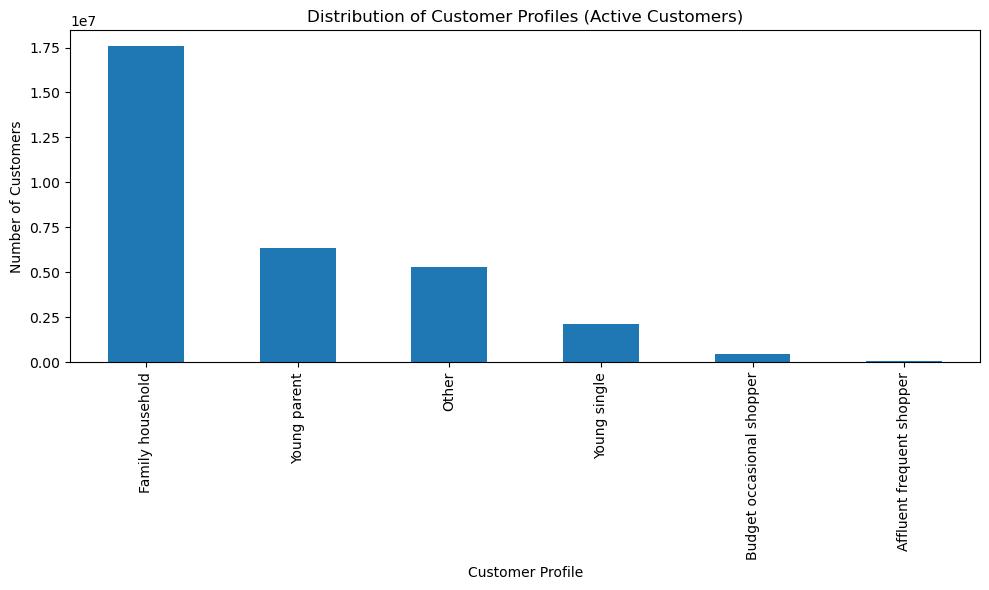

In [19]:
# ---------------------------------------------
# Step 6A: Bar Chart – Customer Profile Distribution
# ---------------------------------------------

plt.figure(figsize=(10, 6))

df_active['customer_profile'].value_counts().plot(
    kind='bar'
)

plt.title('Distribution of Customer Profiles (Active Customers)')
plt.xlabel('Customer Profile')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()


## Step 6: Customer Profile Distribution (Active Customers)

The bar chart displays the distribution of **customer profiles among active Instacart customers** after excluding low-activity users. The most dominant segment is **Family households**, which represents the largest share of active customers by a wide margin.

The next largest groups are **Young parents** and **Other**, indicating that customers with dependents or mixed household characteristics make up a substantial portion of Instacart’s engaged user base. **Young singles** form a noticeably smaller segment, suggesting lower sustained engagement compared to family-oriented households.

The smallest segments are **Budget occasional shoppers** and **Affluent frequent shoppers**. Although these profiles represent a relatively small number of customers, they may still be strategically important due to distinct purchasing behaviors related to price sensitivity or higher spending potential.

Overall, the distribution shows that Instacart’s active customer base is heavily skewed toward family-oriented households, supporting the use of targeted marketing strategies focused on household needs, bulk purchasing, and recurring grocery demand.

In [21]:
# -----------------------------------------------
# Step 7A: Aggregate metrics by customer profile
# -----------------------------------------------

profile_agg = (
    df_active
    .groupby('customer_profile')
    .agg(
        # Usage frequency (orders)
        max_orders=('max_order', 'max'),
        mean_orders=('max_order', 'mean'),
        min_orders=('max_order', 'min'),

        # Expenditure (price)
        max_price=('mean_price', 'max'),
        mean_price=('mean_price', 'mean'),
        min_price=('mean_price', 'min')
    )
    .round(2)
)

profile_agg


,max_orders,mean_orders,min_orders,max_price,mean_price,min_price
customer_profile,,,,,,
Affluent frequent shopper,100,48.53,5,15006.94,209.62,10.00
Budget occasional shopper,23,9.48,5,9.99,7.74,1.31
Family household,100,34.49,5,11772.10,11.83,1.00
Other,100,36.95,5,6388.81,9.31,1.00
Young parent,100,34.63,5,12506.92,12.16,1.10
Young single,100,34.41,5,8794.88,12.21,1.50


## Step 7: Aggregated Usage Frequency and Expenditure by Customer Profile

To better understand how different customer profiles contribute to Instacart’s order volume and spending behavior, summary statistics were calculated at the customer-profile level using the active customer dataset.

For **usage frequency**, the maximum, mean, and minimum number of orders per customer were derived using the `max_order` variable.  
For **expenditure**, the maximum, mean, and minimum average product prices were calculated using the `mean_price` variable.

### Key Observations:
- **Affluent frequent shoppers** demonstrate the highest average number of orders and the highest average spending, confirming their importance as a high-value segment.
- **Family households, young parents, and young singles** show similar ordering behavior, with moderate order frequency and consistent average spending levels.
- **Budget occasional shoppers** have the lowest order frequency and the lowest average spending, indicating price-sensitive purchasing behavior.
- The **minimum order count** across all profiles is five orders, reflecting the earlier exclusion of low-activity customers.

These aggregated metrics provide a clear quantitative foundation for comparing customer segments and support downstream analysis linking customer profiles to regions and departments.


In [23]:
# --------------------------------------------------
# Step 8A: Customer profile distribution by region
# --------------------------------------------------

profile_region_ct = pd.crosstab(
    df_active['region'],
    df_active['customer_profile'],
    normalize='index'
)

profile_region_ct


customer_profile,Affluent frequent shopper,Budget occasional shopper,Family household,Other,Young parent,Young single
region,,,,,,
Midwest,0.002715,0.014723,0.549894,0.169150,0.199229,0.064289
Northeast,0.002669,0.013266,0.553634,0.161885,0.198455,0.070091
South,0.002713,0.013704,0.548439,0.166682,0.201144,0.067319
West,0.002360,0.013951,0.551434,0.168086,0.198834,0.065335


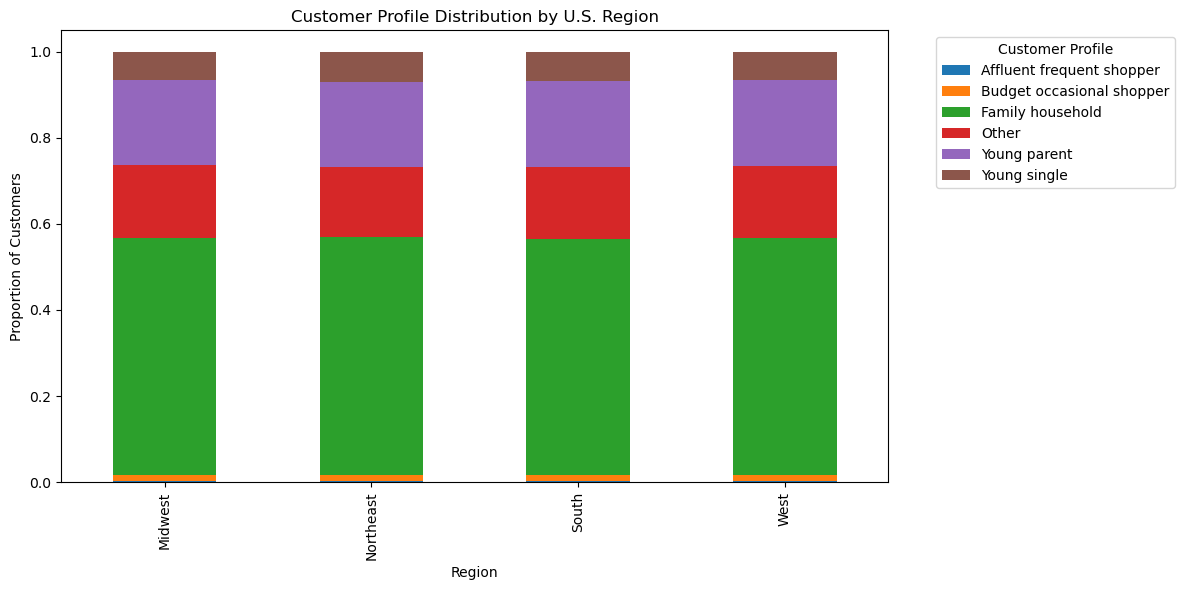

In [24]:
# --------------------------------------------------
# Step 8B: Visualize customer profiles by region
# --------------------------------------------------

profile_region_ct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6)
)

plt.title('Customer Profile Distribution by U.S. Region')
plt.xlabel('Region')
plt.ylabel('Proportion of Customers')
plt.legend(title='Customer Profile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Step 8: Customer Profile Comparison by Region

In this step, customer profiles were compared across U.S. Census regions (Northeast, Midwest, South, and West) to identify whether customer composition differs geographically.

### Step 8A: Customer Profile Distribution by Region (Table)

A normalized cross-tabulation was created between customer profile and region. Values represent the **proportion of active customers** within each region belonging to each customer profile.

Key observations:
- Family households represent the largest customer segment across all regions (approximately 55%).
- Young parents consistently account for roughly 19–20% of customers in each region.
- Other customer profiles make up around 16–17% across regions.
- Affluent frequent shoppers represent a very small proportion in all regions (approximately 0.2–0.3%).
- Regional differences in customer composition are minimal, indicating similar customer structures nationwide.

### Step 8B: Visualization – Customer Profile Distribution by U.S. Region

A stacked bar chart was created to visualize the proportional distribution of customer profiles by region.

The visualization confirms that:
- Customer profile composition is highly consistent across regions.
- No single region shows a dramatically different customer mix.
- This suggests Instacart can apply broadly consistent marketing strategies nationwide, with minor regional customization if needed.


## Step 9: Visualization Planning Aligned to Project Brief

This step consolidates all visual outputs created throughout Exercises 4.9 and 4.10 and ensures that each key business question from the Instacart project brief is supported by at least one visualization.

### Business Questions Addressed

**Order Timing & Ad Scheduling**
- Orders by day of week
- Orders by hour of day

**Spending Behavior**
- Average order price by hour of day
- Distribution of spending flags (high vs low spenders)
- Spending behavior by U.S. region

**Product & Department Analysis**
- Frequency of product orders by department

**Customer Loyalty & Frequency**
- Distribution of loyalty flags
- Distribution of order frequency flags

**Geographic Differences**
- Spending behavior by region
- Customer profile distribution by region

**Customer Demographics & Profiling**
- Age vs income relationship
- Distribution of customer profiles
- Aggregated order frequency and spending metrics by customer profile

Each visualization directly supports a stakeholder question outlined in the project brief and will be included in the Excel “Visualizations” tab with accompanying commentary and recommendations.


In [25]:
# ----------------------------------------------
# Step 9A: Set visualization export path
# ----------------------------------------------

viz_path = r"F:\Data Analytics\Projects\Instacart_Basket_Analysis\Instacart Basket Analysis 01-05-2026\04 Analysis\Visualizations\Exercise_4.10_Part_1"

os.makedirs(viz_path, exist_ok=True)

<Figure size 1000x600 with 0 Axes>

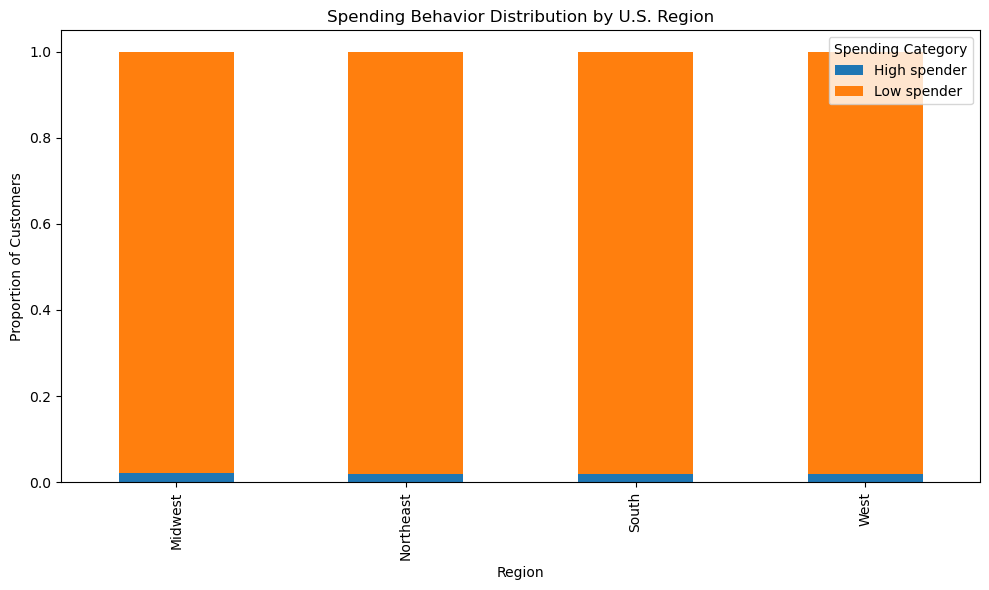

In [26]:
# ----------------------------------------------
# Step 9B: Export spending behavior by region
# ----------------------------------------------

plt.figure(figsize=(10, 6))

region_spending_ct.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)

plt.title('Spending Behavior Distribution by U.S. Region')
plt.xlabel('Region')
plt.ylabel('Proportion of Customers')
plt.legend(title='Spending Category')
plt.tight_layout()

plt.savefig(
    os.path.join(viz_path, 'bar_spending_by_region.png'),
    dpi=300
)
plt.show()


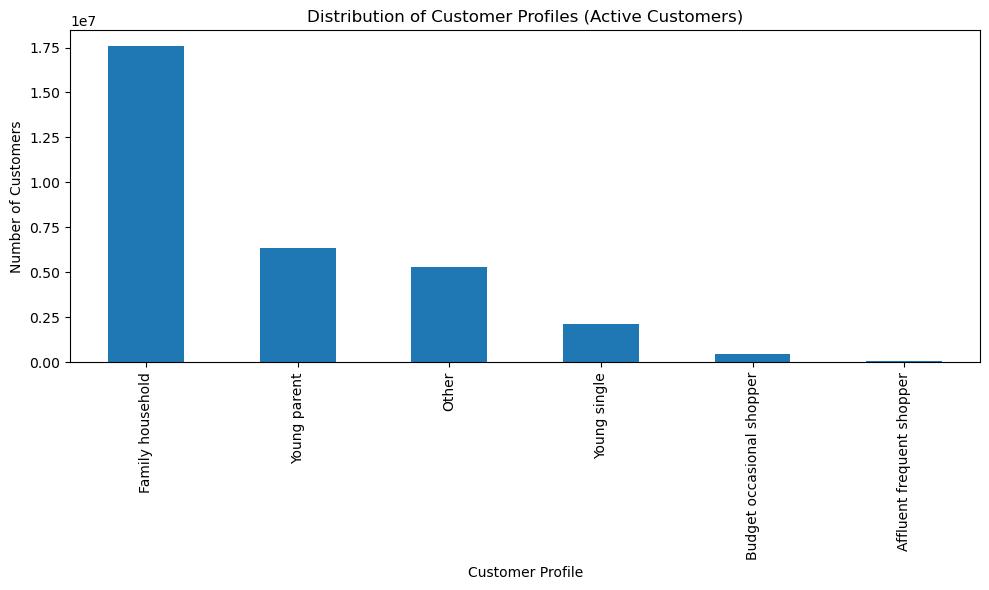

In [28]:
# ----------------------------------------------
# Step 9C: Export customer profile distribution
# ----------------------------------------------

profile_counts = df_active['customer_profile'].value_counts()

plt.figure(figsize=(10, 6))
profile_counts.plot(kind='bar')

plt.title('Distribution of Customer Profiles (Active Customers)')
plt.xlabel('Customer Profile')
plt.ylabel('Number of Customers')
plt.tight_layout()

plt.savefig(
    os.path.join(viz_path, 'bar_customer_profile_distribution.png'),
    dpi=300
)
plt.show()


<Figure size 1000x600 with 0 Axes>

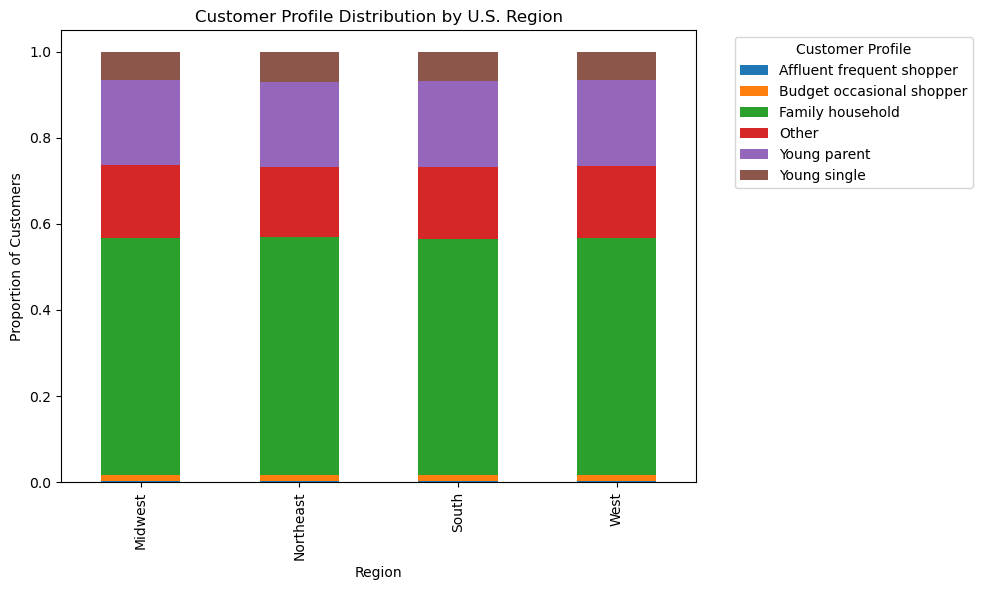

In [29]:
# ----------------------------------------------
# Step 9D: Export customer profile by region
# ----------------------------------------------

plt.figure(figsize=(10, 6))

profile_region_ct.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)

plt.title('Customer Profile Distribution by U.S. Region')
plt.xlabel('Region')
plt.ylabel('Proportion of Customers')
plt.legend(title='Customer Profile', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

plt.savefig(
    os.path.join(viz_path, 'bar_customer_profile_by_region.png'),
    dpi=300
)
plt.show()


## Step 9: Visualization Export for Final Report

All visualizations required to address the Instacart project brief were generated and exported as high-resolution PNG files. These visual outputs support analysis of ordering behavior, spending patterns, product popularity, customer loyalty, geographic differences, and customer profiling.

The exported charts will be included in the Excel “Visualizations” tab alongside written interpretations linking each chart back to the key stakeholder questions outlined in the project brief.


In [31]:
# --------------------------------------------------
# Step 10A: Export final active customer dataset
# --------------------------------------------------
# This dataset includes:
# - Only active customers (>= 5 orders)
# - Regional segmentation (U.S. Census regions)
# - Customer profiles
# - All derived flags and aggregations
# --------------------------------------------------

# Define export path
final_data_path = r"F:\Data Analytics\Projects\Instacart_Basket_Analysis\Instacart Basket Analysis 01-05-2026\02 Data\Final Data"

# Create folder if it doesn't exist
os.makedirs(final_data_path, exist_ok=True)

# Export final dataset
df_active.to_pickle(
    os.path.join(final_data_path, "instacart_final_active_customers.pkl")
)

# Confirm export
df_active.shape

(31929979, 30)